# Acoustic Characteristics Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
import librosa.display
import tqdm
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# set up paths
DATA_DIR = Path('../data/raw')
TRAIN_AUDIO_DIR = DATA_DIR / 'train_audio'
TRAIN_CSV = DATA_DIR / 'train.csv'
TAXONOMY_CSV = DATA_DIR / 'taxonomy.csv'

In [3]:
# load data
train_df = pd.read_csv(TRAIN_CSV)
taxonomy_df = pd.read_csv(TAXONOMY_CSV)

In [4]:
# join with taxonomy to get class information
train_with_taxonomy = pd.merge(
    train_df,
    taxonomy_df[['primary_label', 'class_name']],
    on = 'primary_label',
    how = 'left'
)

In [5]:
# create a cache file path
features_cache_path = Path('../data/interim/acoustic_features.pkl')
os.makedirs('../data/interim', exist_ok=True)

In [6]:
def extract_features(audio_path, sr=32000):
    """Extract acoustic features from an audio file."""
    try:
        # load audio
        y, sr = librosa.load(str(audio_path), sr=sr)

        # basic features
        duration = librosa.get_duration(y=y, sr=sr)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y)[0])
        energy = np.mean(librosa.feature.rms(y=y)[0])

        # spectral features
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)[0])
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])

        # MFCC features
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_means = np.mean(mfccs, axis=1)

        # temporal features
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

        # create feature dictionary
        features = {
            'duration': duration,
            'zero_crossing_rate': zero_crossing_rate,
            'energy': energy,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'spectral_rolloff': spectral_rolloff,
            'tempo': tempo
        }

        # add MFCCs
        for i, mfcc_val in enumerate(mfcc_means):
            features[f'mfcc_{i+1}'] = mfcc_val

        return features
    
    except Exception as e:
        print(f'Error processing {audio_path}: {e}')
        return None

In [8]:
# load or compute features
if os.path.exists(features_cache_path):
    print('Loading cached acoustic features...')
    with open(features_cache_path, 'rb') as f:
        features_data = pickle.load(f)
else:
    print('Extracting acoustic features...')
    features_data = []

    sample_size = len(train_with_taxonomy)
    sampled_data = train_with_taxonomy.groupby('class_name').apply(
        lambda x: x.sample(min(len(x), int(sample_size / len(train_with_taxonomy['class_name'].unique()))))
    ).reset_index(drop=True)

    for _, row in tqdm.tqdm(sampled_data.iterrows(), total=len(sampled_data)):
        audio_path = TRAIN_AUDIO_DIR / row['filename']
        if audio_path.exists():
            features = extract_features(audio_path)
            if features:
                features['primary_label'] = row['primary_label']
                features['common_name'] = row['common_name']
                features['class_name'] = row['class_name']
                features['filename'] = row['filename']
                features_data.append(features)

    # save to cache
    with open(features_cache_path, 'wb') as f:
        pickle.dump(features_data, f)

Extracting acoustic features...


100%|██████████| 8057/8057 [1:20:27<00:00,  1.67it/s]  


In [21]:
# convert to DataFrame
features_df = pd.DataFrame(features_data)
features_df = features_df.replace([np.inf, -np.inf], np.nan).dropna()

In [24]:
acoustic_features = [
    'zero_crossing_rate', 'energy', 'spectral_centroid', 
    'spectral_bandwidth', 'spectral_rolloff'
]

In [25]:
# prepare data for PCA
feature_columns = [col for col in features_df.columns if col.startswith('mfcc_')
                   or col in acoustic_features]
X = features_df[feature_columns].dropna()

In [26]:
# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
# apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

In [28]:
# create DataFrame for plotting
pca_df = pd.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'class_name': features_df.loc[X.index, 'class_name']
})

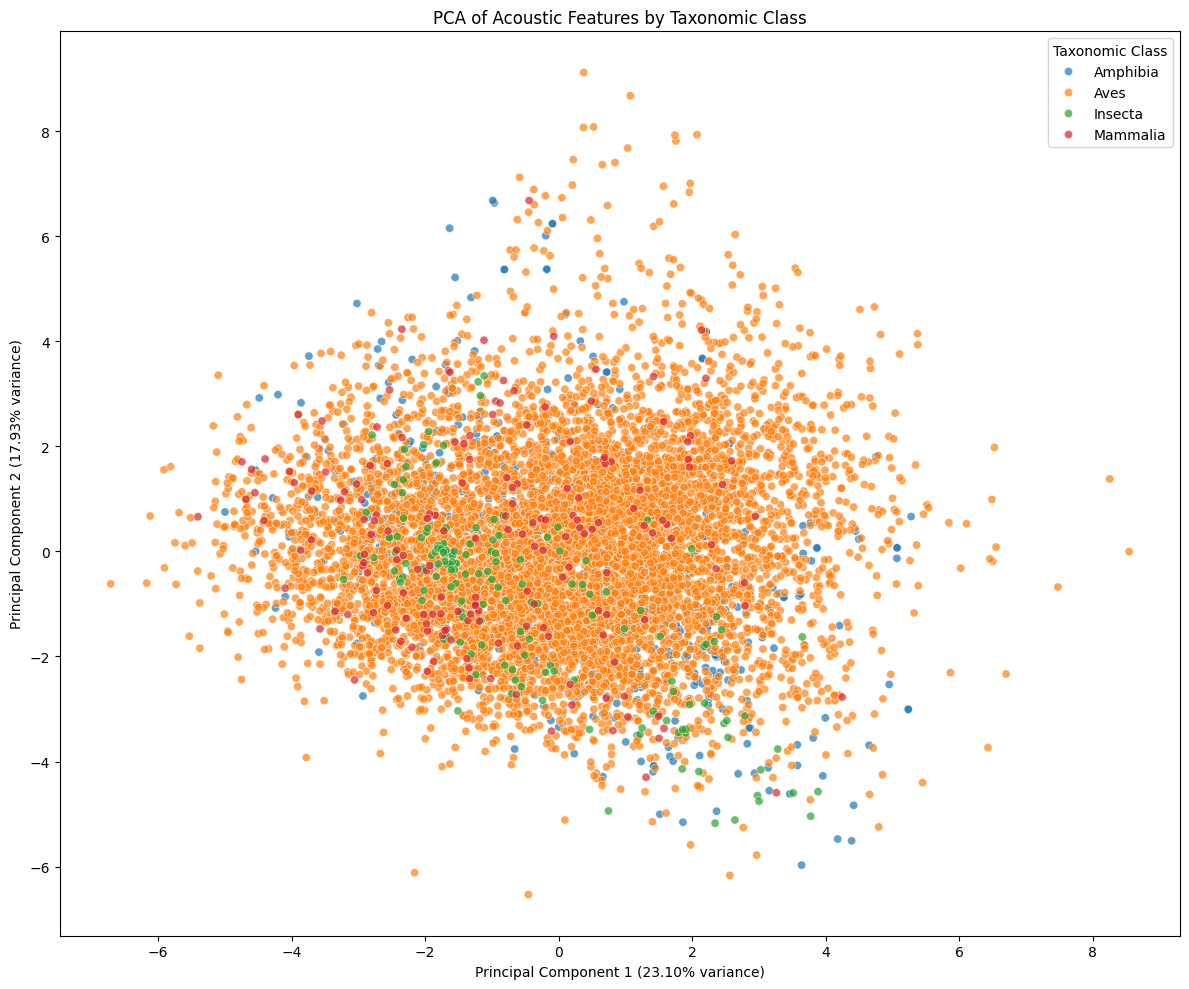

In [29]:
# plt PCA results
plt.figure(figsize=(12, 10))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='class_name', alpha=0.7)
plt.title('PCA of Acoustic Features by Taxonomic Class')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(title='Taxonomic Class')
plt.tight_layout()
plt.show()

In [30]:
# create feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'PC1_contribution': np.abs(pca.components_[0]),
    'PC2_contribution': np.abs(pca.components_[1])
})
feature_importance = feature_importance.sort_values('PC1_contribution', ascending=False)

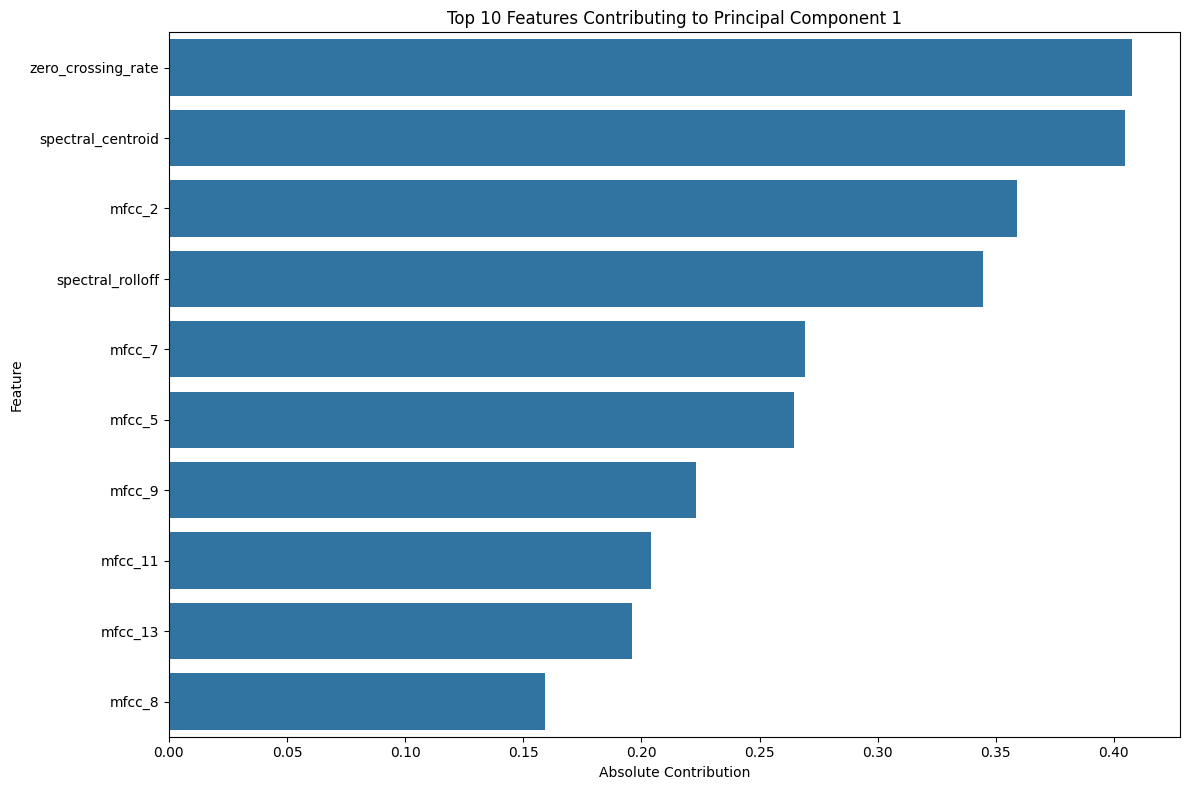

In [31]:
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), y='feature', x='PC1_contribution')
plt.title('Top 10 Features Contributing to Principal Component 1')
plt.xlabel('Absolute Contribution')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [32]:
# save the features data
features_df.to_csv('../data/interim/acoustic_features.csv', index=False)